### Concrete ML configuration with docker (didn't work)
https://docs.zama.ai/concrete-ml/get-started/pip_installing#installation-using-docker
Installation only available via [Docker](https://docs.docker.com/desktop/install/windows-install/) on Windows Machine.
```docker
docker pull zamafhe/concrete-ml:latest
```


### Concrete ML configuration with Windows Subsystem for Linux (WSL)

- install WSL with Powershell: 
```powershell
        wsl --install
```
- install conda and setup env with python 3.11, [installation guide](https://gist.github.com/kauffmanes/5e74916617f9993bc3479f401dfec7da)
- install concrete ML
```bash
        pip install -U pip wheel setuptools
        pip install concrete-ml
```
- configure interpreter under WSL (e.g. via [Pycharm](https://www.jetbrains.com/help/pycharm/using-wsl-as-a-remote-interpreter.html))

![pycharm_wls](pycharm_wsl.png)

## Demonstrate key generation and encryption with homomorphic encryption

In [39]:
# Import necessary libraries
from concrete import fhe
import numpy as np

# Define the identity function
def identity_function(x):
    return x

# Create a compiler object for the identity function
compiler = fhe.Compiler(identity_function, {"x": "encrypted"})

# Compile the function to obtain a homomorphic circuit
circuit = compiler.compile(inputset)

# Generate the keyset (public and secret keys)
keyset = circuit.keygen()

# Sample plaintext data as a NumPy array
plaintext = np.array([2024], dtype=np.int64)
print("Plaintext Data:", plaintext)

Plaintext Data: [2024]


In [40]:
# Encrypt the plaintext data
ciphertext = circuit.encrypt(plaintext)
print("\nEncrypted Data Object:")
print(ciphertext)

# (Optional) Examine encrypted data properties
print("\nType of Encrypted Data:", type(ciphertext))
print("Ciphertext Attributes:", dir(ciphertext))


Encrypted Data Object:

Type of Encrypted Data: <class 'concrete.fhe.compilation.value.Value'>
Ciphertext Attributes: ['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'deserialize', 'inner', 'serialize']


In [41]:
# Serialize the ciphertext to bytes for inspection
serialized_ciphertext = ciphertext.serialize()
hex_representation = serialized_ciphertext.hex()

# Print only the first 200 characters of the hex representation
print("\nSerialized Ciphertext (Hex - First 150 chars):", hex_representation[:150] + '...')
print("Serialized Ciphertext Length:", len(hex_representation))


Serialized Ciphertext (Hex - First 150 chars): 01000000d1020000030000000000000000000000000003000800000000000100e80a000001000100f40a000001000100010000000e00000001000000c2ad000039df87d09e80dce086bd92...
Serialized Ciphertext Length: 11616


In [42]:
# Decrypt the encrypted data
decrypted_output = circuit.decrypt(ciphertext)
print("\nDecrypted Output:", decrypted_output)


Decrypted Output: [2024]


Simply put, the encryption process transforms the plaintext data into a ciphertext object that conceals the original value, and reading the bytes value is like gibberish to the naked eye. The decryption process reverses this transformation to recover the original plaintext value.

## Homomorphic Encryption in Machine Learning with Concrete-ML

This Jupyter Notebook demonstrates how to use homomorphic encryption (HE) with machine learning models using the Concrete-ML library. We'll train three different models in plaintext and then apply homomorphic encryption to perform encrypted inference with the same models.

Models Used:

1. Logistic Regression
2. Decision Tree Classifier
3. Random Forest Classifier

Important Note on Concrete-ML:
- Concrete-ML supports specific models that can be compiled into their FHE counterparts, such as Logistic Regression, Decision Trees, Random Forests, and Neural Networks. But not XGBoost/LightGBM models.

In [22]:
# Import necessary libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learn modules
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Import Concrete-ML libraries
from concrete.ml.sklearn import LogisticRegression as HELogisticRegression
from concrete.ml.sklearn import DecisionTreeClassifier as HEDecisionTreeClassifier
from concrete.ml.sklearn import RandomForestClassifier as HERandomForestClassifier

# Import scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [23]:
# Load the Breast Cancer Wisconsin dataset
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

# Create a DataFrame for better visualization and manipulation
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Check for missing values
print(f"Missing values in dataset: {df.isnull().sum().sum()}")

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('target', axis=1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df['target'], test_size=0.2, random_state=42
)

# Print dataset sizes
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Missing values in dataset: 0
Training samples: 455
Testing samples: 114


In [24]:
def evaluate_model(model, model_name, X_test, y_test):
    """
    Evaluates the model's performance on the test set.

    Parameters:
    - model: Trained machine learning model.
    - model_name: Name of the model (string).
    - X_test: Test features.
    - y_test: Test labels.

    Returns:
    - accuracy: Accuracy score.
    - inference_time: Time taken for inference.
    """
    # Perform prediction
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Accuracy: {accuracy * 100:.2f}%")
    print(f"Inference Time: {inference_time:.6f} seconds")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    return accuracy, inference_time


#### Logistic Regression

In [25]:
# Initialize the Logistic Regression model (plaintext)
lr_plaintext = LogisticRegression(max_iter=1000)
start_time = time.time()
lr_plaintext.fit(X_train, y_train)
lr_plaintext_training_time = time.time() - start_time

# Evaluate the plaintext model
lr_plaintext_accuracy, lr_plaintext_time = evaluate_model(
    lr_plaintext, "Logistic Regression (Plaintext)", X_test, y_test
)


Logistic Regression (Plaintext) Accuracy: 97.37%
Inference Time: 0.000143 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [26]:
# Initialize the Logistic Regression model with Concrete-ML
lr_he = HELogisticRegression(n_bits=7, max_iter=1000)
start_time = time.time()
lr_he.fit(X_train, y_train)
lr_he_training_time = time.time() - start_time

# Compile the model for FHE execution
print("Compiling Logistic Regression model for FHE...")
lr_he.compile(X_train)

# Perform encrypted inference on the test set
start_time = time.time()
y_pred_he = lr_he.predict(X_test)
lr_he_inference_time = time.time() - start_time

# Evaluate the HE model
lr_he_accuracy = accuracy_score(y_test, y_pred_he)
print(f"\nLogistic Regression (HE) Accuracy: {lr_he_accuracy * 100:.2f}%")
print(f"Encrypted Inference Time: {lr_he_inference_time:.6f} seconds")
print(f"Classification Report:\n{classification_report(y_test, y_pred_he)}")


Compiling Logistic Regression model for FHE...

Logistic Regression (HE) Accuracy: 97.37%
Encrypted Inference Time: 0.000376 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



#### Decision Tree Classifier

In [27]:
# Initialize the Decision Tree Classifier (plaintext)
dt_plaintext = DecisionTreeClassifier(random_state=42, max_depth=5)
start_time = time.time()
dt_plaintext.fit(X_train, y_train)
dt_plaintext_training_time = time.time() - start_time

# Evaluate the plaintext model
dt_plaintext_accuracy, dt_plaintext_time = evaluate_model(
    dt_plaintext, "Decision Tree Classifier (Plaintext)", X_test, y_test
)



Decision Tree Classifier (Plaintext) Accuracy: 94.74%
Inference Time: 0.000292 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        43
           1       0.96      0.96      0.96        71

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [28]:
# Initialize the Decision Tree Classifier with Concrete-ML
dt_he = HEDecisionTreeClassifier(n_bits=7, random_state=42, max_depth=5)
start_time = time.time()
dt_he.fit(X_train, y_train)
dt_he_training_time = time.time() - start_time

# Compile the model for FHE execution
print("Compiling Decision Tree model for FHE...")
dt_he.compile(X_train)

# Perform encrypted inference on the test set
start_time = time.time()
y_pred_he = dt_he.predict(X_test)
dt_he_inference_time = time.time() - start_time

# Evaluate the HE model
dt_he_accuracy = accuracy_score(y_test, y_pred_he)
print(f"\nDecision Tree Classifier (HE) Accuracy: {dt_he_accuracy * 100:.2f}%")
print(f"Encrypted Inference Time: {dt_he_inference_time:.6f} seconds")
print(f"Classification Report:\n{classification_report(y_test, y_pred_he)}")


Compiling Decision Tree model for FHE...

Decision Tree Classifier (HE) Accuracy: 96.49%
Encrypted Inference Time: 0.001087 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        43
           1       0.97      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



#### Random Forest Classifier

In [29]:
# Initialize the Random Forest Classifier (plaintext)
rf_plaintext = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=5)
start_time = time.time()
rf_plaintext.fit(X_train, y_train)
rf_plaintext_training_time = time.time() - start_time

# Evaluate the plaintext model
rf_plaintext_accuracy, rf_plaintext_time = evaluate_model(
    rf_plaintext, "Random Forest Classifier (Plaintext)", X_test, y_test
)



Random Forest Classifier (Plaintext) Accuracy: 95.61%
Inference Time: 0.000668 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [30]:
# Initialize the Random Forest Classifier with Concrete-ML
rf_he = HERandomForestClassifier(n_bits=7, n_estimators=10, random_state=42, max_depth=5)
start_time = time.time()
rf_he.fit(X_train, y_train)
rf_he_training_time = time.time() - start_time

# Compile the model for FHE execution
print("Compiling Random Forest model for FHE...")
rf_he.compile(X_train)

# Perform encrypted inference on the test set
start_time = time.time()
y_pred_he = rf_he.predict(X_test)
rf_he_inference_time = time.time() - start_time

# Evaluate the HE model
rf_he_accuracy = accuracy_score(y_test, y_pred_he)
print(f"\nRandom Forest Classifier (HE) Accuracy: {rf_he_accuracy * 100:.2f}%")
print(f"Encrypted Inference Time: {rf_he_inference_time:.6f} seconds")
print(f"Classification Report:\n{classification_report(y_test, y_pred_he)}")


Compiling Random Forest model for FHE...

Random Forest Classifier (HE) Accuracy: 95.61%
Encrypted Inference Time: 0.002957 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



#### Results

In [31]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Plaintext Accuracy (%)': [
        lr_plaintext_accuracy * 100,
        dt_plaintext_accuracy * 100,
        rf_plaintext_accuracy * 100
    ],
    'Encrypted Accuracy (%)': [
        lr_he_accuracy * 100,
        dt_he_accuracy * 100,
        rf_he_accuracy * 100
    ],
    'Plaintext Inference Time (s)': [
        lr_plaintext_time,
        dt_plaintext_time,
        rf_plaintext_time
    ],
    'Encrypted Inference Time (s)': [
        lr_he_inference_time,
        dt_he_inference_time,
        rf_he_inference_time
    ],
    'Plaintext Training Time (s)': [
        lr_plaintext_training_time,
        dt_plaintext_training_time,
        rf_plaintext_training_time
    ],
    'Encrypted Training Time (s)': [
        lr_he_training_time,
        dt_he_training_time,
        rf_he_training_time
    ]
})

# Calculate the increase percentage for inference time
results_df['Inference Time Increase (%)'] = (
    (results_df['Encrypted Inference Time (s)'] - results_df['Plaintext Inference Time (s)'])
    / results_df['Plaintext Inference Time (s)']
) * 100

# Handle division by zero or very small plaintext times
results_df['Inference Time Increase (%)'] = results_df['Inference Time Increase (%)'].replace([np.inf, -np.inf], np.nan)
results_df['Inference Time Increase (%)'] = results_df['Inference Time Increase (%)'].fillna(0).round(2)

# Calculate the increase percentage for Training time
results_df['Training Time Increase (%)'] = (
    (results_df['Encrypted Training Time (s)'] - results_df['Plaintext Training Time (s)'])
    / results_df['Plaintext Training Time (s)']
) * 100

# Handle division by zero or very small plaintext times
results_df['Training Time Increase (%)'] = results_df['Training Time Increase (%)'].replace([np.inf, -np.inf], np.nan)
results_df['Training Time Increase (%)'] = results_df['Training Time Increase (%)'].fillna(0).round(2)


# Display the accuracy table
print("\nModel Accuracy Comparison:")
display(results_df[['Model', 'Plaintext Accuracy (%)', 'Encrypted Accuracy (%)']])

# Display the inference time table
print("\nInference Time Comparison with Increase Percentage:")
display(results_df[['Model', 'Plaintext Inference Time (s)', 'Encrypted Inference Time (s)', 'Inference Time Increase (%)']])

# Display the training time table
print("\nTraining Time Comparison:")
display(results_df[['Model', 'Plaintext Training Time (s)', 'Encrypted Training Time (s)', 'Training Time Increase (%)']])



Model Accuracy Comparison:


,Model,Plaintext Accuracy (%),Encrypted Accuracy (%)
0,Logistic Regression,97.368421,97.368421
1,Decision Tree,94.736842,96.491228
2,Random Forest,95.614035,95.614035



Inference Time Comparison with Increase Percentage:


,Model,Plaintext Inference Time (s),Encrypted Inference Time (s),Inference Time Increase (%)
0,Logistic Regression,0.000143,0.000376,163.00
1,Decision Tree,0.000292,0.001087,272.08
2,Random Forest,0.000668,0.002957,342.68



Training Time Comparison:


,Model,Plaintext Training Time (s),Encrypted Training Time (s),Training Time Increase (%)
0,Logistic Regression,0.011007,0.055396,403.29
1,Decision Tree,0.007414,0.135682,1730.11
2,Random Forest,0.019657,0.174091,785.64


In [32]:
print("Columns in results_df:", results_df.columns.tolist())

Columns in results_df: ['Model', 'Plaintext Accuracy (%)', 'Encrypted Accuracy (%)', 'Plaintext Inference Time (s)', 'Encrypted Inference Time (s)', 'Plaintext Training Time (s)', 'Encrypted Training Time (s)', 'Inference Time Increase (%)', 'Training Time Increase (%)']


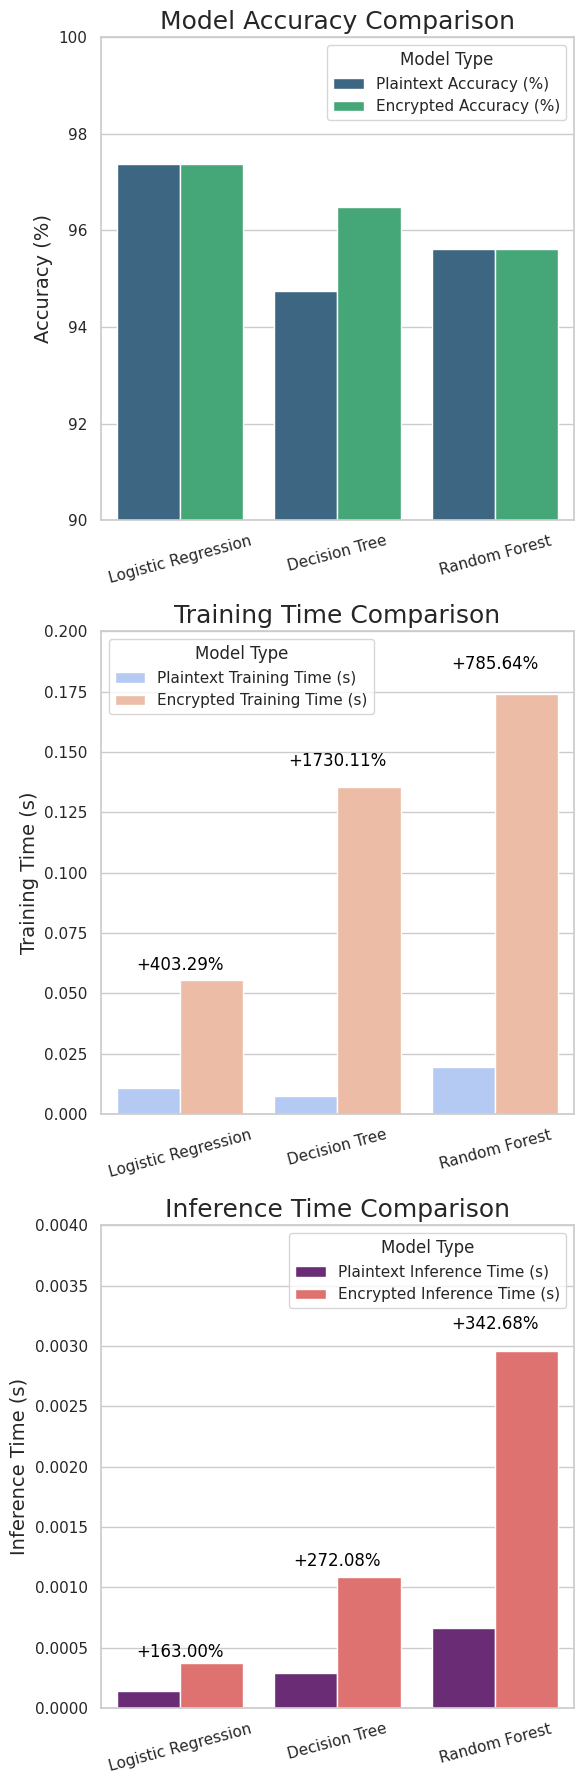

In [45]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Set the overall figure size (adjust the height to accommodate 3 plots)
plt.figure(figsize=(6, 18))  # Width x Height in inches

# --------------------------
# 1. Plot Accuracy Comparison
# --------------------------
plt.subplot(3, 1, 1)  # 3 rows, 1 column, subplot 1

# Melt the DataFrame for seaborn
accuracy_melted = results_df.melt(
    id_vars='Model',
    value_vars=['Plaintext Accuracy (%)', 'Encrypted Accuracy (%)'],
    var_name='Type',
    value_name='Accuracy (%)'
)

# Create a barplot
sns.barplot(
    data=accuracy_melted,
    x='Model',
    y='Accuracy (%)',
    hue='Type',
    palette='viridis'
)

# Add title and labels
plt.title('Model Accuracy Comparison', fontsize=18)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xlabel('')
plt.xticks(rotation=15)
plt.ylim(90, 100)  # Adjust based on your accuracy range
plt.legend(title='Model Type')

# --------------------------
# 2. Plot Inference Time Comparison
# --------------------------
plt.subplot(3, 1, 3)  # 3 rows, 1 column, subplot 2

# Melt the DataFrame for seaborn
inference_melted = results_df.melt(
    id_vars='Model',
    value_vars=['Plaintext Inference Time (s)', 'Encrypted Inference Time (s)'],
    var_name='Type',
    value_name='Inference Time (s)'
)

# Create a barplot
sns.barplot(
    data=inference_melted,
    x='Model',
    y='Inference Time (s)',
    hue='Type',
    palette='magma'
)

# Add title and labels
plt.title('Inference Time Comparison', fontsize=18)
plt.ylabel('Inference Time (s)', fontsize=14)
plt.xlabel('')
plt.xticks(rotation=15)
plt.ylim(0,0.004) 
plt.legend(title='Model Type')

# Add annotations for increase percentage
for idx, row in results_df.iterrows():
    model_name = row['Model']
    encrypted_time = row['Encrypted Inference Time (s)']
    percentage_increase = row['Inference Time Increase (%)']
    plt.text(
        idx,
        encrypted_time + encrypted_time * 0.05,
        f"+{percentage_increase:.2f}%",
        ha='center',
        va='bottom',
        fontsize=12,
        color='black'
    )

# --------------------------
# 3. Plot Training Time Comparison
# --------------------------
plt.subplot(3, 1, 2)  # 3 rows, 1 column, subplot 3

# Melt the DataFrame for seaborn
training_melted = results_df.melt(
    id_vars='Model',
    value_vars=['Plaintext Training Time (s)', 'Encrypted Training Time (s)'],
    var_name='Type',
    value_name='Training Time (s)'
)

# Create a barplot
sns.barplot(
    data=training_melted,
    x='Model',
    y='Training Time (s)',
    hue='Type',
    palette='coolwarm'
)

# Add title and labels
plt.title('Training Time Comparison', fontsize=18)
plt.ylabel('Training Time (s)', fontsize=14)
plt.xlabel('')
plt.xticks(rotation=15)
plt.ylim(0, 0.2) 
plt.legend(title='Model Type')

# Add annotations for increase percentage
for idx, row in results_df.iterrows():
    model_name = row['Model']
    encrypted_time = row['Encrypted Training Time (s)']
    percentage_increase = row['Training Time Increase (%)']
    plt.text(
        idx,
        encrypted_time + encrypted_time * 0.05,
        f"+{percentage_increase:.2f}%",
        ha='center',
        va='bottom',
        fontsize=12,
        color='black'
    )

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()



##### **Conclusion on Accuracy:**

- **Consistency:** For **Logistic Regression** and **Random Forest**, HE maintained the same level of accuracy as plaintext models.
- **Enhanced Performance:** For **Decision Tree**, HE slightly improved accuracy, which is an unexpected and positive outcome. However, it's essential to verify if this improvement is consistent across multiple runs or datasets to rule out anomalies.

##### **Conclusion on Inference Time:**

- **Performance Overhead:** HE introduces a **significant** computational overhead in inference times across all models, especially in Decision Trees and Random Forests.
- **Acceptability:** While the overhead is substantial, the trade-off might be acceptable depending on the application's privacy requirements. For real-time applications, this delay could be problematic, whereas, for batch processing, it might be manageable.

##### **Conclusion on Training Time:**

- **Significant Overhead:** HE introduces a **massive** increase in training times across all models.
- **Practical Implications:** Such overheads may limit the practicality of training HE models, especially with larger datasets or more complex models. Consider pre-training models in plaintext and only performing encrypted inference if real-time or frequent retraining isn't required.



#### Experiments with Different n_bits Values on Decision Tree Classifier

In [34]:
# Iterate over different n_bits values for HE Decision Tree and tabulate results

# Define the list of n_bits to test
n_bits_list = [1,2,3,4,5,6,7,8,9,10,11,12,13]

# Initialize a list to store the results
results = []

for n_bits in n_bits_list:
    print(f"Processing n_bits={n_bits}...")
    
    # Initialize the HE Decision Tree Classifier with the current n_bits
    dt_he = HEDecisionTreeClassifier(n_bits=n_bits, random_state=42, max_depth=5)
    
    # Measure training time
    start_time = time.time()
    dt_he.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Compile the model for FHE execution
    print("Compiling Decision Tree model for FHE...")
    dt_he.compile(X_train)
    
    # Measure inference time
    start_time = time.time()
    y_pred_he = dt_he.predict(X_test)
    inference_time = time.time() - start_time
    
    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred_he) * 100
    
    # Append the results to the list
    results.append({
        'n_bits': n_bits,
        'Training Time (s)': training_time,
        'Inference Time (s)': inference_time,
        'Accuracy (%)': accuracy
    })
    
    print(f"n_bits={n_bits} - Accuracy: {accuracy:.2f}%, Training Time: {training_time:.6f}s, Inference Time: {inference_time:.6f}s\n")

# Create a DataFrame to display the results
results_df_nbits = pd.DataFrame(results)

Processing n_bits=1...
Compiling Decision Tree model for FHE...
n_bits=1 - Accuracy: 70.18%, Training Time: 0.185805s, Inference Time: 0.001367s

Processing n_bits=2...
Compiling Decision Tree model for FHE...
n_bits=2 - Accuracy: 86.84%, Training Time: 0.229184s, Inference Time: 0.009635s

Processing n_bits=3...
Compiling Decision Tree model for FHE...
n_bits=3 - Accuracy: 92.98%, Training Time: 0.272223s, Inference Time: 0.000998s

Processing n_bits=4...
Compiling Decision Tree model for FHE...
n_bits=4 - Accuracy: 93.86%, Training Time: 0.189365s, Inference Time: 0.001595s

Processing n_bits=5...
Compiling Decision Tree model for FHE...
n_bits=5 - Accuracy: 92.98%, Training Time: 0.239687s, Inference Time: 0.000997s

Processing n_bits=6...
Compiling Decision Tree model for FHE...
n_bits=6 - Accuracy: 94.74%, Training Time: 0.113724s, Inference Time: 0.001529s

Processing n_bits=7...
Compiling Decision Tree model for FHE...
n_bits=7 - Accuracy: 96.49%, Training Time: 0.200992s, Infer

In [35]:
# Display the results table
print("HE Decision Tree Performance with Different n_bits:")
display(results_df_nbits)


HE Decision Tree Performance with Different n_bits:


,n_bits,Training Time (s),Inference Time (s),Accuracy (%)
0,1,0.185805,0.001367,70.175439
1,2,0.229184,0.009635,86.842105
2,3,0.272223,0.000998,92.982456
3,4,0.189365,0.001595,93.859649
4,5,0.239687,0.000997,92.982456
5,6,0.113724,0.001529,94.736842
6,7,0.200992,0.001526,96.491228
7,8,0.231422,0.001596,93.859649
8,9,0.118032,0.000971,96.491228
9,10,0.115174,0.001018,96.491228


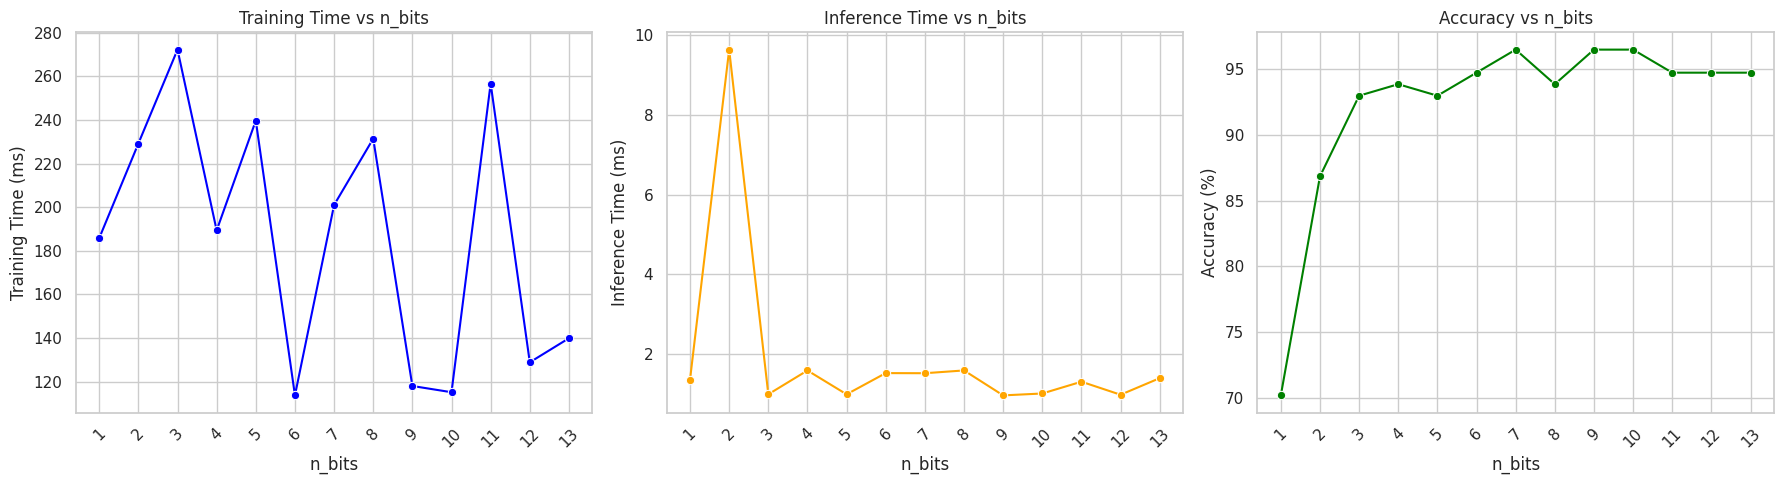

In [36]:
# Plot Training Time, Inference Time, and Accuracy separately across different n_bits arranged side by side

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that the DataFrame 'results_df' exists with the required columns
# If not, replace 'results_df' with your actual DataFrame variable name

# Convert times to milliseconds for better visualization
results_df_nbits['Training Time (ms)'] = results_df_nbits['Training Time (s)'] * 1000
results_df_nbits['Inference Time (ms)'] = results_df_nbits['Inference Time (s)'] * 1000

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with three horizontally arranged subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Plot Training Time vs n_bits
sns.lineplot(data=results_df_nbits, x='n_bits', y='Training Time (ms)', marker='o', color='blue', ax=axes[0])
axes[0].set_title('Training Time vs n_bits')
axes[0].set_xlabel('n_bits')
axes[0].set_ylabel('Training Time (ms)')
axes[0].set_xticks(results_df_nbits['n_bits'])
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# 2. Plot Inference Time vs n_bits
sns.lineplot(data=results_df_nbits, x='n_bits', y='Inference Time (ms)', marker='o', color='orange', ax=axes[1])
axes[1].set_title('Inference Time vs n_bits')
axes[1].set_xlabel('n_bits')
axes[1].set_ylabel('Inference Time (ms)')
axes[1].set_xticks(results_df_nbits['n_bits'])
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)

# 3. Plot Accuracy vs n_bits
sns.lineplot(data=results_df_nbits, x='n_bits', y='Accuracy (%)', marker='o', color='green', ax=axes[2])
axes[2].set_title('Accuracy vs n_bits')
axes[2].set_xlabel('n_bits')
axes[2].set_ylabel('Accuracy (%)')
axes[2].set_xticks(results_df_nbits['n_bits'])
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()


**Overall Insights:**

- **Optimal Precision:** Setting `n_bits` between **7 and 9** offers the best balance between high accuracy (~96.49%) and reasonable training/inference times.
  
- **Diminishing Returns:** Increasing `n_bits` beyond 9 does not yield significant accuracy improvements and may introduce unnecessary computational overhead.
  
- **Low Precision Risks:** Using very low `n_bits` (e.g., 1 or 3) severely hampers model performance, highlighting the importance of sufficient precision in HE-based models.
  
- **Inference Efficiency:** Despite variations in `n_bits`, inference times remain low and relatively unaffected, making HE Decision Trees feasible for scenarios where prediction speed is critical.


## TODO
- [x] Evaluate the n-bits effect on the accuracy and inference time for decision trees model
- [x] Demonstrate the security and privacy benefits of homomorphic encryption with client side decryption and server side encryption.
    - Failed to do the privacy check with DS/MLE  
- [ ] Web application for encrypted inference with homomorphic encryption.
- [ ] Hyperopt experiment with plaintext vs homomorphic encryption for hyperparameter optimization.
- [ ] Demonstrate the use of homomorphic encryption with Neural Networks. {Not doing this, the machine has no GPU support}